## 04 – Probabilistic forecasts

Quantile regression and conformal prediction intervals.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src.data import load_opsd_germany
from src.features import make_features
from src.models import train_point_model, train_quantile_models, predict_quantiles
from src.conformal import compute_absolute_residuals, conformal_interval
from src.evaluation import (
    regression_metrics,
    interval_coverage,
    interval_width,
    quantile_calibration,
    plot_quantile_calibration,
)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

In [4]:
# Load data & create train/cal/test splits
raw = load_opsd_germany(str(PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv"))
X, y = make_features(raw, horizon=1, target_col="load")

# 60/20/20 split by time index
n = len(X)
cutoff_train = X.index[int(0.6 * n)]
cutoff_cal = X.index[int(0.8 * n)]

X_train = X[X.index < cutoff_train]
y_train = y[y.index < cutoff_train]

X_cal = X[(X.index >= cutoff_train) & (X.index < cutoff_cal)]
y_cal = y[(y.index >= cutoff_train) & (y.index < cutoff_cal)]

X_test = X[X.index >= cutoff_cal]
y_test = y[X.index >= cutoff_cal]

X_train.shape, X_cal.shape, X_test.shape


((29958, 28), (9986, 28), (9986, 28))

In [5]:
# Quantile regression
quantiles = [0.1, 0.5, 0.9]
q_models = train_quantile_models(X_train, y_train, quantiles=quantiles)
q_preds_test = predict_quantiles(q_models, X_test)
q_preds_test.head()


,q_0.1,q_0.5,q_0.9
utc_timestamp,,,
2019-08-11 21:00:00+00:00,39454.867008,40511.196433,42263.213012
2019-08-11 22:00:00+00:00,38136.997914,38900.165161,40040.052083
2019-08-11 23:00:00+00:00,36986.692763,38033.753090,38730.343768
2019-08-12 00:00:00+00:00,37868.351413,38610.258461,39186.831669
2019-08-12 01:00:00+00:00,38729.861230,38850.220642,39668.434422


In [6]:
# Compute coverage & width (e.g., 80% interval)
lower_q = q_preds_test["q_0.1"].values
upper_q = q_preds_test["q_0.9"].values
median_q = q_preds_test["q_0.5"].values

coverage_q = interval_coverage(y_test, lower_q, upper_q)
width_q = interval_width(lower_q, upper_q)
point_metrics_q = regression_metrics(y_test, median_q)

coverage_q, width_q, point_metrics_q


(0.7792910074103745,
 2504.423594775794,
 {'MAE': 685.153112981041, 'RMSE': 965.947009884587})

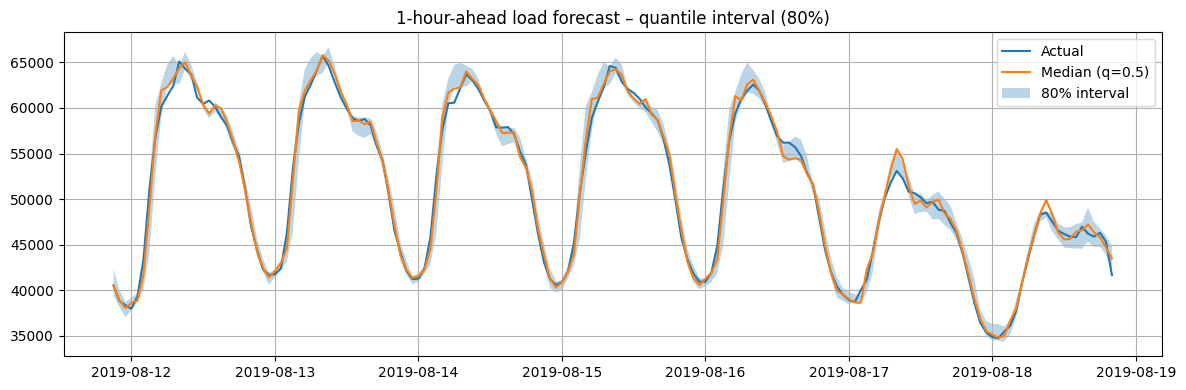

In [7]:
# Plot sample week with quantile band
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, median_q[sample], label="Median (q=0.5)")
plt.fill_between(time, lower_q[sample], upper_q[sample], alpha=0.3, label="80% interval")

plt.title("1-hour-ahead load forecast – quantile interval (80%)")
plt.legend()
plt.tight_layout()
plt.show()


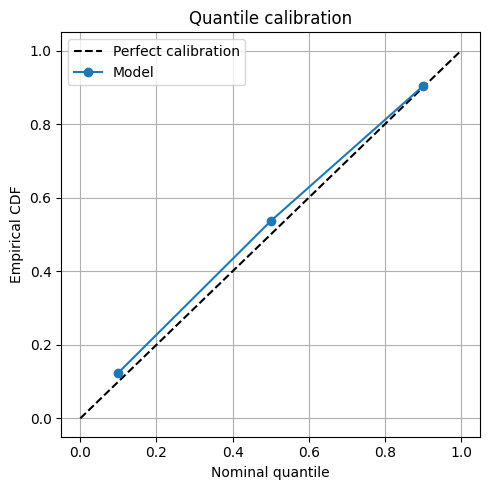

In [8]:
# Quantile calibration plot
calib_df = quantile_calibration(
    y_true=y_test.values,
    q_pred_dict={
        0.1: q_preds_test["q_0.1"].values,
        0.5: q_preds_test["q_0.5"].values,
        0.9: q_preds_test["q_0.9"].values,
    },
)
calib_df
plot_quantile_calibration(calib_df)


In [9]:
# Conformal prediction
point_model = train_point_model(X_train, y_train)
residuals = compute_absolute_residuals(point_model, X_cal, y_cal)
np.quantile(residuals, [0.5, 0.8, 0.9, 0.95])


array([ 463.10774284,  956.29820477, 1299.02289534, 1688.1373201 ])

In [10]:
# Build conformal intervals on test
alpha = 0.1  # 90% target coverage
lower_conf, upper_conf = conformal_interval(model=point_model, X=X_test, residuals=residuals, alpha=alpha)
y_pred_point_test = point_model.predict(X_test)

coverage_conf = interval_coverage(y_test, lower_conf, upper_conf)
width_conf = interval_width(lower_conf, upper_conf)
point_metrics_conf = regression_metrics(y_test, y_pred_point_test)

coverage_conf, width_conf, point_metrics_conf


(0.8638093330662928,
 2598.045790686476,
 {'MAE': 674.907649951304, 'RMSE': 905.598981028686})

In [11]:
# Compare quantile vs conformal
results = pd.DataFrame({
    "method": ["quantile_80", "conformal_90"],
    "coverage": [coverage_q, coverage_conf],
    "avg_width": [width_q, width_conf],
    "MAE": [point_metrics_q["MAE"], point_metrics_conf["MAE"]],
    "RMSE": [point_metrics_q["RMSE"], point_metrics_conf["RMSE"]],
})
results


,method,coverage,avg_width,MAE,RMSE
0,quantile_80,0.779291,2504.423595,685.153113,965.947010
1,conformal_90,0.863809,2598.045791,674.907650,905.598981


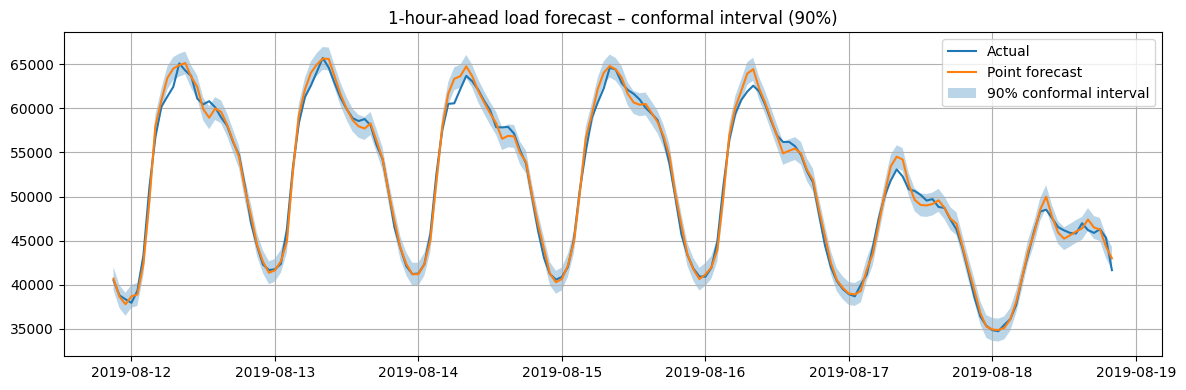

In [12]:
# Plot conformal band for a sample week
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, y_pred_point_test[sample], label="Point forecast")
plt.fill_between(time, lower_conf[sample], upper_conf[sample], alpha=0.3, label="90% conformal interval")

plt.title("1-hour-ahead load forecast – conformal interval (90%)")
plt.legend()
plt.tight_layout()
plt.show()
